In [1]:
import os
from keras.layers import Input
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
from tensorflow.python.framework.ops import disable_eager_execution
from tqdm import tqdm
from tensorflow.keras import mixed_precision

In [2]:
# set up tf enviroment
disable_eager_execution()

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

#set memory growth
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#set precision piolicy
mixed_precision.set_global_policy(mixed_precision.Policy('mixed_float16'))

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3080, compute capability 8.6


In [3]:
IMG_SIZE = 224
base_dir = "./ranzcr_clip_catheter_line_classification/"

train_df = pd.read_csv(os.path.join(base_dir, "train_sorted.csv"))
train_df.nunique()
train_df.head()
#3255 unique patients, We want to make sure that each patient's images do not appear in multiple folds to avoid data leakage

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.10000428974990117276...,0,0,0,0,0,0,0,0,0,1,0,04cfbc3d2
1,1.2.826.0.1.3680043.8.498.10001065121843652267...,0,0,0,0,0,0,0,0,0,1,0,176a5edfd
2,1.2.826.0.1.3680043.8.498.10001175380298620851...,0,0,0,0,0,0,0,0,0,1,0,d57f48a31
3,1.2.826.0.1.3680043.8.498.10001274045312501651...,0,0,0,0,0,0,0,0,0,1,0,e252d355a
4,1.2.826.0.1.3680043.8.498.10001645884963994872...,0,0,1,0,0,1,0,0,1,1,0,8849382d0


In [4]:
#some patients have over 100 images and some have only 1
train_df.PatientID.value_counts()

05029c63a    172
55073fece    167
26da0d5ad    148
8849382d0    130
34242119f    110
            ... 
abd4f9903      1
fcdbe09ab      1
0e42f8bda      1
854849171      1
18b5a482b      1
Name: PatientID, Length: 3255, dtype: int64

                  Malpositions  Number of Observations
0               ETT - Abnormal                      79
1             ETT - Borderline                    1138
2                 ETT - Normal                    7240
3               NGT - Abnormal                     279
4             NGT - Borderline                     529
5    NGT - Incompletely Imaged                    2748
6                 NGT - Normal                    4797
7               CVC - Abnormal                    3195
8             CVC - Borderline                    8460
9                 CVC - Normal                   21324
10  Swan Ganz Catheter Present                     830


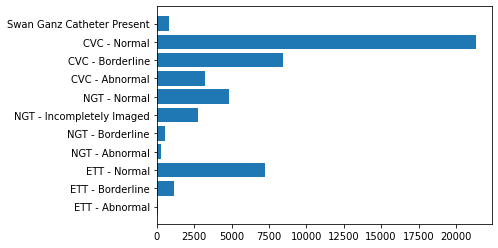

In [5]:
#plot label distribution
categories = ['ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal','Swan Ganz Catheter Present']
categoryCounts = train_df[categories].sum(axis = 0).reset_index()
categoryCounts.columns = ['Malpositions', 'Number of Observations']
plt.barh(categoryCounts['Malpositions'], categoryCounts['Number of Observations'])

print(categoryCounts)

In [6]:
#load data
data = pickle.load(open("Combined.pickle", "rb"))

print(data.shape)

(30083, 13)


In [7]:
#scale to 0-1
Xtrain = np.array(data[:, 0])
Xtrain_scaled = []
for pic in tqdm(Xtrain):
    Xtrain_scaled.append(np.array(pic/255).astype(np.float32))

print(np.array(Xtrain_scaled).shape)

100%|██████████| 30083/30083 [00:11<00:00, 2595.82it/s]


(30083, 224, 224)


In [8]:
#split data
Xtrain, Xtest, Xvalidation, yTrain_EET, yTrain_NGT, yTrain_CVC, yTrain_SG, yTest_EET, yTest_NGT, yTest_CVC, yTest_SG, yValidation_EET, yValidation_NGT, yValidation_CVC, yValidation_SG = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[]

for i in range(len(Xtrain_scaled)):

    if data[i][12]==4:
        Xtest.append(Xtrain_scaled[i])
        yTest_EET.append(data[i, 1:4])
        yTest_NGT.append(data[i, 4:8])
        yTest_CVC.append(data[i, 8:11])
        yTest_SG.append(data[i, 11:12])

    elif data[i][12]==3:
        Xvalidation.append(Xtrain_scaled[i])
        yValidation_EET.append(data[i, 1:4])
        yValidation_NGT.append(data[i, 4:8])
        yValidation_CVC.append(data[i, 8:11])
        yValidation_SG.append(data[i, 11:12])

    else:
        Xtrain.append(Xtrain_scaled[i])
        yTrain_EET.append(data[i, 1:4])
        yTrain_NGT.append(data[i, 4:8])
        yTrain_CVC.append(data[i, 8:11])
        yTrain_SG.append(data[i, 11:12])

In [9]:
#reshape and make all lists numpy arrays
Xtrain = np.array(Xtrain).reshape((-1,IMG_SIZE,IMG_SIZE,1))
yTrain_EET = np.array(yTrain_EET)
yTrain_NGT = np.array(yTrain_NGT)
yTrain_CVC = np.array(yTrain_CVC)
yTrain_SG = np.array(yTrain_SG)

Xtest = np.array(Xtest).reshape((-1,IMG_SIZE,IMG_SIZE,1))
yTest_EET = np.array(yTest_EET)
yTest_NGT = np.array(yTest_NGT)
yTest_CVC = np.array(yTest_CVC)
yTest_SG = np.array(yTest_SG)

Xvalidation = np.array(Xvalidation).reshape((-1,IMG_SIZE,IMG_SIZE,1))
yValidation_EET = np.array(yValidation_EET)
yValidation_NGT = np.array(yValidation_NGT)
yValidation_CVC = np.array(yValidation_CVC)
yValidation_SG = np.array(yValidation_SG)

print(len(Xtrain))
print(np.array(Xtrain).shape)
print(len(yTrain_EET))
print(len(Xvalidation))
print(np.array(Xvalidation).shape)
print(len(yValidation_CVC))
print(len(Xtest))
print(np.array(Xtest).shape)
print(len(yTest_NGT))

18035
(18035, 224, 224, 1)
18035
6018
(6018, 224, 224, 1)
6018
6030
(6030, 224, 224, 1)
6030


In [10]:
def plot_hist(hist, name, loss):
    fig, ax = plt.subplots(1,2)
    fig.tight_layout(h_pad=2)
    ax[0].plot(hist.history[loss+"_accuracy"])
    ax[0].plot(hist.history["val_"+loss+"_accuracy"])
    ax[0].set_title("Model "+name+" Accuracy")
    ax[0].set_ylabel("Validation Accuracy")
    ax[0].set_xlabel("Epoch")
    ax[0].legend(["Train Acc", "Validation Acc"], loc="lower right")
    ax[1].plot(hist.history["loss"])
    ax[1].plot(hist.history["val_loss"])
    ax[1].set_title("Model "+name+" Loss")
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("Epoch")
    ax[1].legend(["Train Loss", "Validation Loss"], loc="upper right")

Train on 18035 samples, validate on 6018 samples
Epoch 1/10
18035/18035 [==============================] - ETA: 0s - loss: 0.3362 - binary_accuracy: 0.8839   

c:\users\spencer\documents\ece9309\kagglecomp\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


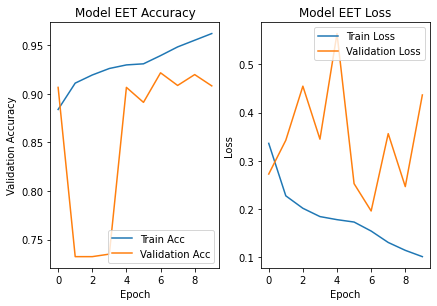

In [11]:
#EET Model
input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
model_EET = tf.keras.applications.EfficientNetB0(weights=None, input_tensor=input, classes=3, classifier_activation='sigmoid')

#model_EET.summary()
model_EET.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['binary_accuracy'])

checkpoint_path = "training_EET/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

hist_EET = model_EET.fit(x=Xtrain, y=yTrain_EET, epochs=10, batch_size=128, validation_data=(Xvalidation, yValidation_EET), callbacks=[cp_callback])
#batchsize 128 = 70s, 32=270s, 64=150s, 96 = 100s

plot_hist(hist_EET, 'EET', 'binary')
score = model_EET.evaluate(Xtest, yTest_EET)
print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

Train on 18035 samples, validate on 6018 samples
Epoch 1/10
18035/18035 [==============================] - ETA: 0s - loss: 0.3411 - binary_accuracy: 0.8871   

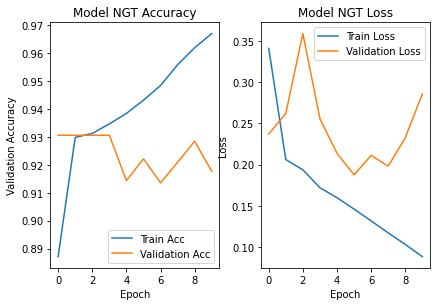

In [12]:
#NGT Model
input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
model_NGT = tf.keras.applications.EfficientNetB0(weights=None, input_tensor=input, classes=4, classifier_activation='sigmoid')

#model_NGT.summary()
model_NGT.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['binary_accuracy'])

checkpoint_path = "training_NGT/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

hist_NGT = model_NGT.fit(x=Xtrain, y=yTrain_NGT, epochs=10, batch_size=128, validation_data=(Xvalidation, yValidation_NGT), callbacks=[cp_callback])

plot_hist(hist_NGT, "NGT", "binary")
score = model_NGT.evaluate(Xtest, yTest_NGT)
print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

Train on 18035 samples, validate on 6018 samples
Epoch 1/10
18035/18035 [==============================] - ETA: 0s - loss: 1.5503 - binary_accuracy: 0.6248   

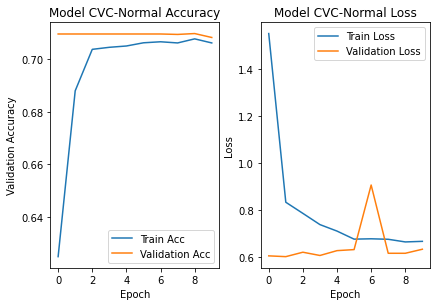

In [13]:
#CVC_normal Model
input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
model_CVC_normal = tf.keras.applications.EfficientNetB0(include_top=True, weights=None, input_tensor=input, classes=1, classifier_activation='sigmoid')

#model_CVC_normal.summary()
model_CVC_normal.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['binary_accuracy'])

checkpoint_path = "training_CVC_normal/cp.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

hist_CVC_normal = model_CVC_normal.fit(x=Xtrain, y=yTrain_CVC[:, 2], epochs=10, batch_size=128, validation_data=(Xvalidation, yValidation_CVC[:, 2]), callbacks=[cp_callback])

plot_hist(hist_CVC_normal, "CVC-Normal", "binary")
score = model_CVC_normal.evaluate(Xtest, yTest_CVC[:, 2])
print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

Train on 18035 samples, validate on 6018 samples
Epoch 1/10
18035/18035 [==============================] - ETA: 0s - loss: 1.2267 - binary_accuracy: 0.6634   

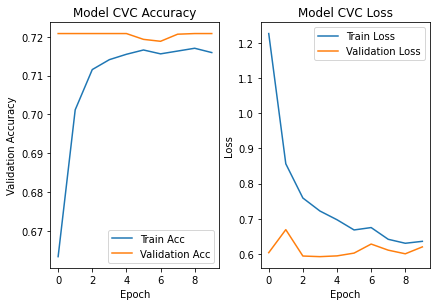

In [14]:
#CVC-borderline Model
input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
model_CVC_borderline = tf.keras.applications.EfficientNetB0(include_top=True, weights=None, input_tensor=input, classes=1, classifier_activation='sigmoid')

#model_CVC_borderline.summary()
model_CVC_borderline.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['binary_accuracy'])

checkpoint_path = "training_CVC_borderline/cp.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

hist_CVC_borderline = model_CVC_borderline.fit(x=Xtrain, y=yTrain_CVC[:, 1], epochs=10, batch_size=128, validation_data=(Xvalidation, yValidation_CVC[:, 1]), callbacks=[cp_callback])

plot_hist(hist_CVC_borderline, "CVC-Borderline", "binary")
score = model_CVC_borderline.evaluate(Xtest, yTest_CVC[:, 1])
print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

Train on 18035 samples, validate on 6018 samples
Epoch 1/10
18035/18035 [==============================] - ETA: 0s - loss: 0.9128 - binary_accuracy: 0.8031   

c:\users\spencer\documents\ece9309\kagglecomp\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


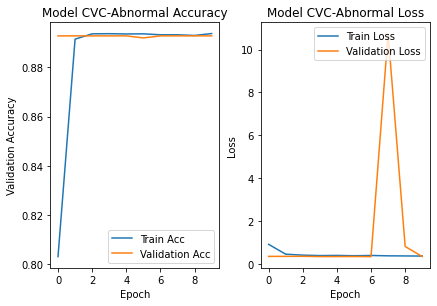

In [20]:
#CVC-abnormal Model
input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
model_CVC_abnormal = tf.keras.applications.EfficientNetB0(include_top=True, weights=None, input_tensor=input, classes=1, classifier_activation='sigmoid')

#model_CVC_abnormal.summary()
model_CVC_abnormal.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['binary_accuracy'])

checkpoint_path = "training_CVC_abnormal/cp.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

hist_CVC_abnormal = model_CVC_abnormal.fit(x=Xtrain, y=yTrain_CVC[:, 0], epochs=10, batch_size=128, validation_data=(Xvalidation, yValidation_CVC[:, 0]), callbacks=[cp_callback])

plot_hist(hist_CVC_abnormal, "CVC-Abnormal", "binary")
score = model_CVC_abnormal.evaluate(Xtest, yTest_CVC[:, 0])
print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

Train on 18035 samples, validate on 6018 samples
Epoch 1/10
18035/18035 [==============================] - ETA: 0s - loss: 0.3731 - binary_accuracy: 0.9420   

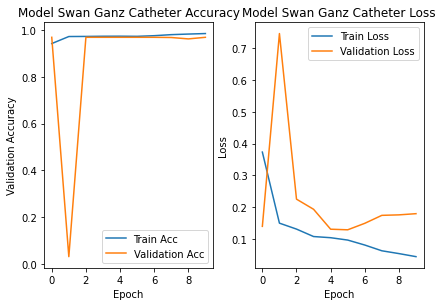

In [16]:
#Swan Ganz Catheter Model
input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
model_SG = tf.keras.applications.EfficientNetB0(weights=None, input_tensor=input, classes=1, classifier_activation='sigmoid')

#model_CVC.summary()
model_SG.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['binary_accuracy'])

checkpoint_path = "training_SG/cp.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

hist_SG = model_SG.fit(x=Xtrain, y=yTrain_SG, epochs=10, batch_size=128, validation_data=(Xvalidation, yValidation_SG), callbacks=[cp_callback])

Test Loss:  0.14450506713259872
Test Accuracy:  0.9719735


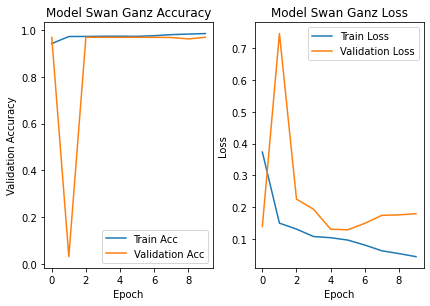

In [17]:
plot_hist(hist_SG, "Swan Ganz", "binary")
score = model_SG.evaluate(Xtest, yTest_SG)
print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])
